<br>
<p style="font-size: 45px;
          text-align:center;
          font-family: 'Times New Roman';
          font-variant: small-caps;
          font-weight: bold;
          line-height: 50px;"> Detección de Suciedad en Paneles Solares</p>
          
<p style="font-size: 20px;
          text-align:center;
          font-family: 'Times New Roman';
          font-variant: small-caps;
          font-weight: italic;
          line-height: 50px;">Parte 2: Extracción de Características</p>


Se procede a encontrar los descriptores de la imagen, basados en indicadores de textura, color, área, entre otros.

# Importar datos de la segmentación

Se leen los datos del dataset creado con la suciedad segmentada

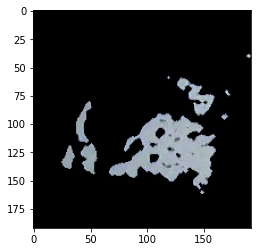

In [1]:
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Se define la ubicación actual del código con la librería Path
cwd = Path.cwd()

# Se declara la ubicación del dataset en cuestion
DATA_PATH_SOILING = cwd / 'datasets' / 'Soiling_data_output'

# Se retornan todos los nombres de las imagenes .jpg en una lista
paneles_sucios = list(DATA_PATH_SOILING.glob('*.jpg'))

# Se organizan de forma aleatoria los datos del dataset
np.random.seed(0)
np.random.shuffle(paneles_sucios )

# Se presenta una imagen del dataset de segmentación
img = plt.imread(paneles_sucios[-5])
plt.imshow(img)

# Se recupera la máscara de segmentación.

Dado que al guardar la imagen se perdió la variable de mascara, esta se recupera ubicando los pixeles negros.



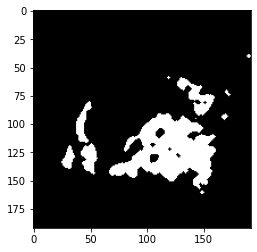

In [2]:
def return_mask(img):
    #Funcion para retornar mascara de la suciedad usando los pixeles que superan cierto umbral
    return (  (img[:,:,0]>8)
             &(img[:,:,0]>8)
             &(img[:,:,0]>8) )*255

# Se ejecuta la funcion
mask=return_mask(img)
# Se muestra la mascara
plt.imshow(mask,cmap='gray')

# Extracción de características

Dado un objeto en cuestión, se requiere obtener las características numéricas y categóricas de las mismas. En el caso de este proyecto se desea encontrar aquellas variables que permitan describir el panel solar bajo análisis.

## Retornar información del etiquetado de la imagen

En el paso de segmentación se encontró el área de la imagen y se adjuntó al etiquetado de la misma, por lo cual se crea una función para retornar dicho valor, y el valor de perdida de potencia medida en el panel

In [3]:
features={}

def get_label_features(img_name,features):
    # Del nombre de la imagen se extrae la información del area.
    features['Area_Per']=str(img_name).split('_')[-1][:-4]
    
    # Del nombre de la imagen se extrae la información de la pérdida en potencia eléctrica.
    features['PowerLoss']=str(img_name).split('_')[-3]
    return features


In [4]:
# Se ejecuta la función creada.
features = get_label_features(paneles_sucios[-5],features)
features

{'Area_Per': '0.24218', 'PowerLoss': '0.844202988023'}

## Descriptores de textura

Se utilizan diferentes descriptores de textura para el espacio de color RGB. Inicialmente se toma la media de cada canal con su correspondiente desviación estándar, adicionalmente se utiliza el apuntamiento o kurtosis para tener información sobre la distribución del histograma entre la parte central y los extremos. Y finalmente, se utiliza el skew el cual suministra información acerca de la asimetría del histograma.

In [19]:
from scipy.stats import skew,kurtosis

def get_rgb_features(img,mask,features):  
    # Se ejecutan los algoritmos de promedio-std-kurtosis-skew sobre cada espacio de color.
    
    features['Red_mean']=np.mean(img[(mask>100),0])
    features['Red_std']=np.std(img[(mask>100),0])
    features['Red_kurtosis'] = kurtosis(img[(mask>100),0])
    features['Red_skew'] = skew(img[(mask>100),0])

    features['Green_mean']=np.mean(img[(mask>100),1])
    features['Green_std']=np.std(img[(mask>100),1])
    features['Green_kurtosis'] = kurtosis(img[(mask>100),1])
    features['Green_skew'] = skew(img[(mask>100),1])

    features['Blue_mean']=np.mean(img[(mask>100),2])
    features['Blue_std']=np.std(img[(mask>100),2])
    features['Blue_kurtosis'] = kurtosis(img[(mask>100),2])
    features['Blue_skew'] = skew(img[(mask>100),2])
    
    
    
    return features

In [20]:
# Se ejecuta la función creada para la imagen de prueba, y se presentan los resultados
features=get_rgb_features(img,mask,features)
features

{'Area_Per': '0.0766',
 'PowerLoss': '0.871656338755',
 'Red_mean': 132.1765557163531,
 'Red_std': 20.31515300662282,
 'Red_kurtosis': 7.550396533865515,
 'Red_skew': -1.6954682673585326,
 'Green_mean': 112.70622286541244,
 'Green_std': 15.301852523588755,
 'Green_kurtosis': 19.76779698828721,
 'Green_skew': -2.2501096120109807,
 'Blue_mean': 100.29667149059334,
 'Blue_std': 18.327112223877805,
 'Blue_kurtosis': 5.881913217752915,
 'Blue_skew': -0.23992873039531876}

In [21]:
import pandas as pd

# Se crea un dataset de pandas con los descriptores encontrados
df=pd.DataFrame(columns=features.keys())
# Se agregan los valores de features en el dataset creado
df=df.append(features,ignore_index=True)
# Se muestra el resultado
df

,Area_Per,PowerLoss,Red_mean,Red_std,Red_kurtosis,Red_skew,Green_mean,Green_std,Green_kurtosis,Green_skew,Blue_mean,Blue_std,Blue_kurtosis,Blue_skew
0,0.0766,0.871656338755,132.176556,20.315153,7.550397,-1.695468,112.706223,15.301853,19.767797,-2.25011,100.296671,18.327112,5.881913,-0.239929


<br>
A continuación, se ejecuta el proceso presentado para todas las imágenes del dataset
<br>

In [26]:
for image_name in paneles_sucios:
    
    # Se lee la imagen
    img = plt.imread(str(image_name))
    
    # Se encuentra la mascara de la imagen
    mask = return_mask(img)
    
    # Se crea un diccionario vacio de descriptores
    features = {}
    
    # Se agregan al diccionario de descriptores los valores del label de cada imagen (Area de suciedad y potencia %)
    features = get_label_features(str(image_name),features)
    
    # Se agregan al diccionario de descriptores los valores de textura Mean-std-kurtosis-skew
    features = get_rgb_features(img,mask,features)
    
    # Se hace el append con el dataframe general
    df = df.append(features,ignore_index=True)
    

In [27]:
df.to_csv('datasets/data.csv')
df

,Area_Per,PowerLoss,Red_mean,Red_std,Red_kurtosis,Red_skew,Green_mean,Green_std,Green_kurtosis,Green_skew,Blue_mean,Blue_std,Blue_kurtosis,Blue_skew
0,0.0766,0.871656338755,132.176556,20.315153,7.550397,-1.695468,112.706223,15.301853,19.767797,-2.250110,100.296671,18.327112,5.881913,-0.239929
1,0.22092,0.658676864705,166.320393,29.955651,1.227137,-1.112640,184.182758,32.090080,1.365387,-1.136582,201.856819,32.971501,1.825720,-1.147361
2,0.03141,0.188745245958,127.229167,34.444293,2.423503,-0.194122,141.857639,34.724369,4.782616,-0.857277,168.597222,37.382514,6.303900,-1.564811
3,0.07437,0.845329524197,129.171514,20.224773,6.210698,-1.470981,108.557047,14.274315,20.562415,-2.346366,98.353468,18.062375,4.804765,-0.330602
4,0.14572,0.14254153713,140.356269,20.876255,4.596895,0.882647,149.259939,20.947247,6.207381,0.781776,168.063073,22.355094,5.914430,0.392586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582,0.24218,0.844202988023,160.620682,17.032052,6.205166,-1.873565,172.445187,17.509650,6.827761,-2.019823,183.970060,18.659141,6.097577,-1.776235
583,0.06499,0.0302054414214,114.222409,30.769344,3.276176,0.527426,134.667228,30.093138,6.540237,-0.742554,168.306655,32.720928,10.662044,-2.029310
584,0.23342,0.642704243533,165.655534,29.061491,1.401353,-1.109943,183.663884,30.824591,1.877945,-1.171462,201.659351,32.160787,2.313132,-1.195929
585,0.30868,0.650890198939,159.573256,36.156897,-0.475406,-0.552524,178.249414,38.550435,-0.179933,-0.590162,198.108848,38.156596,0.607570,-0.706090


---

# Reconocimiento de patrones

Se procede a utilizar un algoritmo que permita establecer la prioridad de mantenimiento que tiene un panel bajo análisis. Para ello se utilizará un proceso de clasificación entre 3 posibles categorías 

* Prioridad Baja (Low)
* Prioridad Media (Medium)
* Prioridad Alta (High)

Sin embargo, se debe notar que la perdida de potencia que se tiene de cada imagen es una variable numérica, por lo cual se pasa a un tipo de variable categórica usando la función cut de pandas

In [28]:
import pandas as pd

# Se genera una copia del dataset General
df2=df.copy()

# Se pasa de variable numérica a variable categórica con la función cut
df2.loc[:,'PowerLoss']=pd.cut(
                                x = np.array(df['PowerLoss'],dtype=np.float32),
                                bins = 3,
                                labels = ["Low", "Medium", "High"]
                            )
# Se presenta el resultado
df2

,Area_Per,PowerLoss,Red_mean,Red_std,Red_kurtosis,Red_skew,Green_mean,Green_std,Green_kurtosis,Green_skew,Blue_mean,Blue_std,Blue_kurtosis,Blue_skew
0,0.0766,High,132.176556,20.315153,7.550397,-1.695468,112.706223,15.301853,19.767797,-2.250110,100.296671,18.327112,5.881913,-0.239929
1,0.22092,High,166.320393,29.955651,1.227137,-1.112640,184.182758,32.090080,1.365387,-1.136582,201.856819,32.971501,1.825720,-1.147361
2,0.03141,Low,127.229167,34.444293,2.423503,-0.194122,141.857639,34.724369,4.782616,-0.857277,168.597222,37.382514,6.303900,-1.564811
3,0.07437,High,129.171514,20.224773,6.210698,-1.470981,108.557047,14.274315,20.562415,-2.346366,98.353468,18.062375,4.804765,-0.330602
4,0.14572,Low,140.356269,20.876255,4.596895,0.882647,149.259939,20.947247,6.207381,0.781776,168.063073,22.355094,5.914430,0.392586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582,0.24218,High,160.620682,17.032052,6.205166,-1.873565,172.445187,17.509650,6.827761,-2.019823,183.970060,18.659141,6.097577,-1.776235
583,0.06499,Low,114.222409,30.769344,3.276176,0.527426,134.667228,30.093138,6.540237,-0.742554,168.306655,32.720928,10.662044,-2.029310
584,0.23342,Medium,165.655534,29.061491,1.401353,-1.109943,183.663884,30.824591,1.877945,-1.171462,201.659351,32.160787,2.313132,-1.195929
585,0.30868,High,159.573256,36.156897,-0.475406,-0.552524,178.249414,38.550435,-0.179933,-0.590162,198.108848,38.156596,0.607570,-0.706090


## Definición de entradas y salidas
<br>
<div style="text-align: justify;width:90%;margin: 0 auto"> 
Para la tarea bajo estudio se requiere tener claro cuál es la salida deseada, en este caso es la prioridad de mantenimiento de un panel (Columna: "PowerLoss"), mientras que, las entradas para el sistema serán el area de la suciedad segmentada y los descriptores de textura presentados (Mean - std - Kurtosis - Skew)
</div>
<br>

A continuación, se separan las entradas de las salidas, para las entradas se tiene:

In [30]:
# Se definen las entradas (X) tomando todas las columnas menos PowerLoss
X_all=df2.loc[:, df2.columns != 'PowerLoss']
# Se presenta el resultado
X_all

,Area_Per,Red_mean,Red_std,Red_kurtosis,Red_skew,Green_mean,Green_std,Green_kurtosis,Green_skew,Blue_mean,Blue_std,Blue_kurtosis,Blue_skew
0,0.0766,132.176556,20.315153,7.550397,-1.695468,112.706223,15.301853,19.767797,-2.250110,100.296671,18.327112,5.881913,-0.239929
1,0.22092,166.320393,29.955651,1.227137,-1.112640,184.182758,32.090080,1.365387,-1.136582,201.856819,32.971501,1.825720,-1.147361
2,0.03141,127.229167,34.444293,2.423503,-0.194122,141.857639,34.724369,4.782616,-0.857277,168.597222,37.382514,6.303900,-1.564811
3,0.07437,129.171514,20.224773,6.210698,-1.470981,108.557047,14.274315,20.562415,-2.346366,98.353468,18.062375,4.804765,-0.330602
4,0.14572,140.356269,20.876255,4.596895,0.882647,149.259939,20.947247,6.207381,0.781776,168.063073,22.355094,5.914430,0.392586
...,...,...,...,...,...,...,...,...,...,...,...,...,...
582,0.24218,160.620682,17.032052,6.205166,-1.873565,172.445187,17.509650,6.827761,-2.019823,183.970060,18.659141,6.097577,-1.776235
583,0.06499,114.222409,30.769344,3.276176,0.527426,134.667228,30.093138,6.540237,-0.742554,168.306655,32.720928,10.662044,-2.029310
584,0.23342,165.655534,29.061491,1.401353,-1.109943,183.663884,30.824591,1.877945,-1.171462,201.659351,32.160787,2.313132,-1.195929
585,0.30868,159.573256,36.156897,-0.475406,-0.552524,178.249414,38.550435,-0.179933,-0.590162,198.108848,38.156596,0.607570,-0.706090


Y para la salidas:

In [31]:
# Se definen las salidas como la columna PowerLoss
Y_all=df2.loc[:,'PowerLoss']
# Se muestran los resultados
Y_all

0        High
1        High
2         Low
3        High
4         Low
        ...  
582      High
583       Low
584    Medium
585      High
586      High
Name: PowerLoss, Length: 587, dtype: category
Categories (3, object): ['Low' < 'Medium' < 'High']

## División de los datos en conjuntos de entrenamiento y validación

En este caso se utilizará un modelo de aprendizaje supervisado, por lo cual se requiere poner a pruebe el modelo generado con datos no usados durante la construcción de este. Con el objetivo de validar el comportamiento del modelo y buscar aquellos problemas que se puedan presentar.

Los datos en cuestión se dividirán en dos conjuntos:

* Train: Estos datos serán los utilizados en la etapa de entrenamiento
* Test: Estos datos serán utilizados en la etapa de validación para verificar la precisión del modelo construido.

El objetivo principal de hacer la división de datos es evitar que el modelo memorice las imágenes de entrenamiento, y logré generalizar el proceso de clasificación de prioridad de mantenimiento en los paneles solares.


In [13]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_all, Y_all)

## Construcción del Modelo



Una vez se tiene la división entre los datos de entrenamiento y de prueba, se procede con la construcción del modelo usando los datos de entrenamiento

### Modelo propuesto (Support Vector Machine - SVM)

Para la tarea en cuestión, se propone hacer uso del algoritmo de máquinas de vectores de soporte (SVM) implementado en la librería sklearn

<img src="res/SVM.jpg" width=500>
<p style="text-align: center">Figura. Concepto del SVM (Suppor Vector Machine) </p>

In [32]:
from sklearn import svm

# Se crea el modelo del SVM
clf = svm.SVC()
# Se entrena el model del SVM
clf.fit(x_train,  y_train)

SVC()

## Evaluación de desempeño

Para probar el comportamiento del modelo entrenado se utiliza la función predict

In [33]:
y_pred = clf.predict(x_test)

Luego se obtiene el puntaje de precisión utilizando la librería metrics de sklearn.

In [34]:
from sklearn.metrics import confusion_matrix, precision_score
print(precision_score(y_test, y_pred, average='weighted'))

0.5684945468187957


Para observa el comportamiento de los resultados obtenidos se realiza una matriz de confusión sobre los datos de prueba.

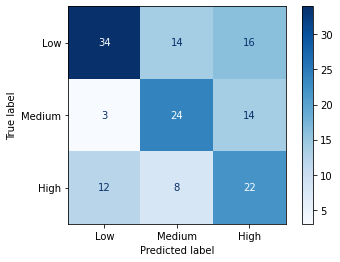

In [17]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt


plot_confusion_matrix(clf, x_test, y_test,
                      cmap=plt.cm.Blues,
                      labels=['Low','Medium','High'],
                      display_labels=['Low','Medium','High'])

Luego se ejectua la matriz de confusión sobre todos los datos para verificar el comportamiento del modelo propuesto.

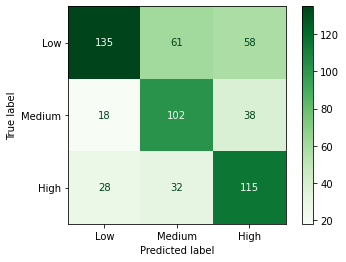

In [18]:
plot_confusion_matrix(clf, X_all, Y_all,
                      cmap=plt.cm.Greens,
                      labels=['Low','Medium','High'],
                      display_labels=['Low','Medium','High'])